# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.ToTensor()])
    
    path = "./" + data_dir
    data = datasets.ImageFolder(root=path, transform=transform)
    loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 150
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

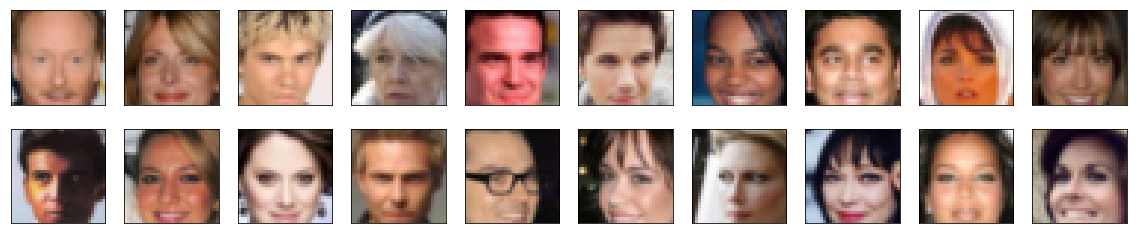

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9216)
Max:  tensor(0.8667)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)
    
    conv_layer1 = nn.Conv2d(out_channels, out_channels, 
                           3, 1, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer1)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    transpose_conv_layer1 = nn.ConvTranspose2d(out_channels, out_channels, 
                                              3, 1, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer1)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    mean = 0.0
    init_gain = 0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean, init_gain)
        #if hasattr(m, 'bias') and m.bias is not None:
        #    init.constant_(m.bias.data, 0.0)
            
    # Dont need to initialise for BatchNorm
    #elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
    #        init.normal_(m.weight.data, 1.0, init_gain)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel

In [17]:
#!pip install torchsummary
#from torchsummary import summary

#print(summary(D, (3, 32, 32))) 
#print(summary(G, (32*4*4*4,100))) 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
   
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

#d_optimizer = optim.SGD(D.parameters(), lr)
#g_optimizer = optim.SGD(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [39]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    #print("number of samples: ",len(samples))
    
    with open('train_samples_40deep.pkl', 'wb') as f:
        pkl.dump({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'd_ptimizer_state_dict': d_optimizer.state_dict(),
            'g_ptimizer_state_dict': g_optimizer.state_dict(),
            'losses': losses,
            'samples' : samples
            }, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [40]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 0.6594 | g_loss: 2.3233
Epoch [    1/   40] | d_loss: 0.5574 | g_loss: 1.3735
Epoch [    1/   40] | d_loss: 0.6369 | g_loss: 1.2104
Epoch [    1/   40] | d_loss: 0.5282 | g_loss: 2.7896
Epoch [    1/   40] | d_loss: 0.5959 | g_loss: 2.7401
Epoch [    1/   40] | d_loss: 0.9649 | g_loss: 2.0650
Epoch [    1/   40] | d_loss: 0.8514 | g_loss: 1.7395
Epoch [    1/   40] | d_loss: 0.4745 | g_loss: 3.0723
Epoch [    1/   40] | d_loss: 0.6367 | g_loss: 3.1696
Epoch [    1/   40] | d_loss: 1.0444 | g_loss: 1.5985
Epoch [    1/   40] | d_loss: 1.0632 | g_loss: 3.8378
Epoch [    1/   40] | d_loss: 0.7752 | g_loss: 2.9694
Epoch [    2/   40] | d_loss: 0.7506 | g_loss: 2.2045
Epoch [    2/   40] | d_loss: 0.6062 | g_loss: 2.6928
Epoch [    2/   40] | d_loss: 0.6051 | g_loss: 2.2086
Epoch [    2/   40] | d_loss: 0.7279 | g_loss: 2.3229
Epoch [    2/   40] | d_loss: 0.8439 | g_loss: 1.8720
Epoch [    2/   40] | d_loss: 0.6306 | g_loss: 2.0398
Epoch [    2/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

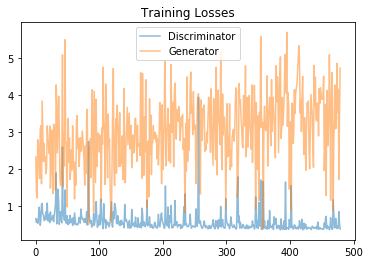

In [43]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [3]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

### Compare results after different epochs

Observations:
- Results generally got better after more epochs of training.

<table><tr>
<td> <p style="text-align: center;">5 epochs <img src='assets/v1_5epochs_loss.JPG' alt="Drawing" width=100%/></td>
<td> <p style="text-align: center;">20 epochs <img src='assets/v1_20epochs_loss.JPG' alt="Drawing" width=100%/> </td>
<td> <p style="text-align: center;">40 epochs <img src='assets/v1_40epochs_loss.JPG' alt="Drawing" width=100%/> </td>
</tr></table>

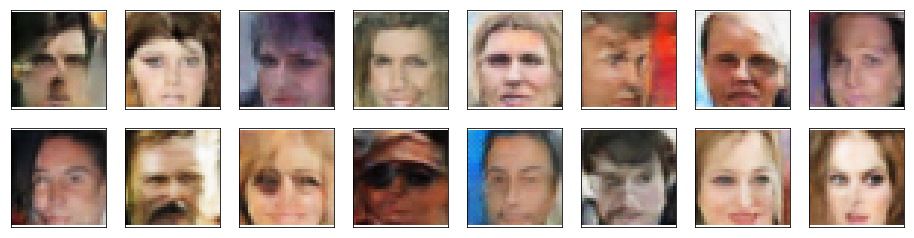

In [25]:
#after 40 epochs
with open('train_samples_40.pkl', 'rb') as f:
    checkpoint = pkl.load(f)
_ = view_samples(-1, checkpoint['samples'])

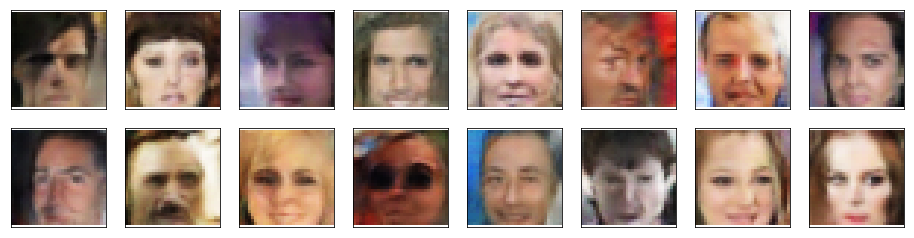

In [26]:
#after 30 epochs
_ = view_samples(-11, checkpoint['samples'])

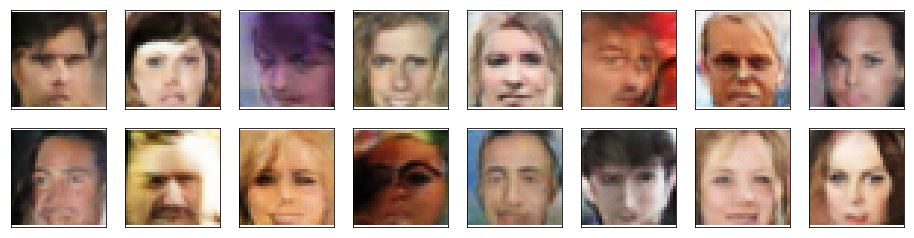

In [27]:
#after 20 epochs
_ = view_samples(-21, checkpoint['samples'])

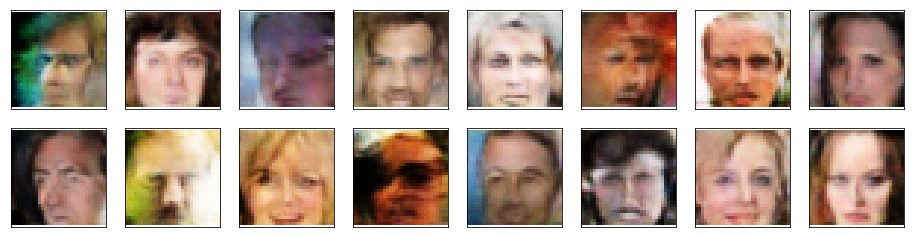

In [28]:
#after 10 epochs
_ = view_samples(-31, checkpoint['samples'])

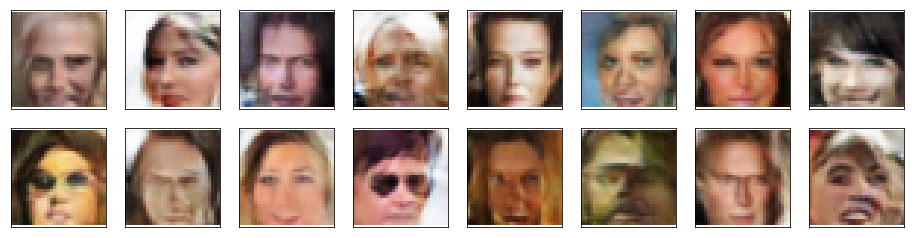

In [36]:
# Load samples from generator, taken while training
with open('train_samples_20.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

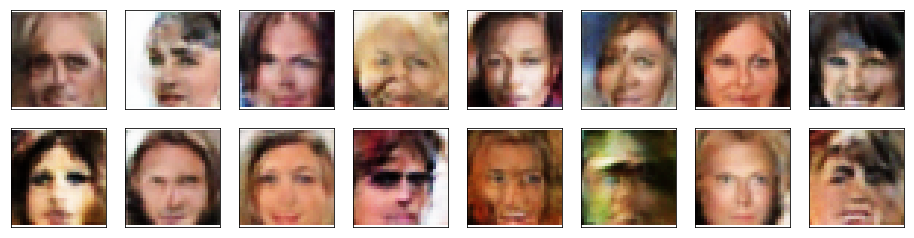

In [37]:
_ = view_samples(-11, samples)

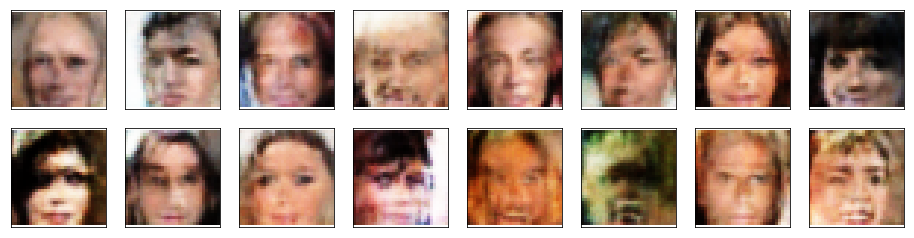

In [38]:
_ = view_samples(4, samples)

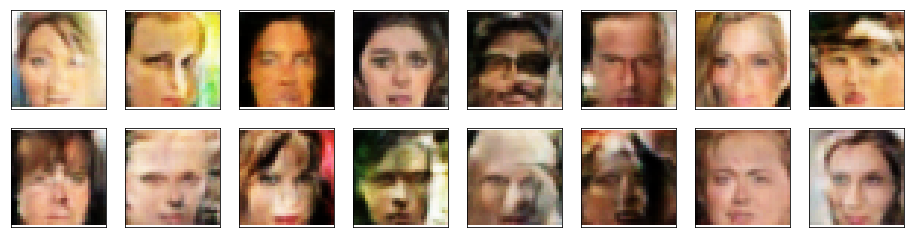

In [32]:
with open('train_samples_10.pkl', 'rb') as f:
    #samples = pkl.load(f, map_location=lambda storage, loc: storage)
    samples = pkl.load(f)
_ = view_samples(-1, samples)

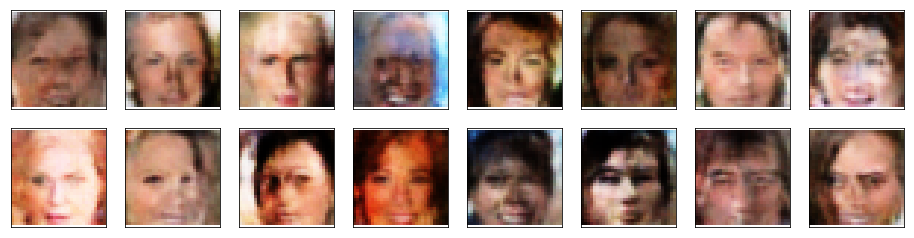

In [33]:
with open('train_samples_5.pkl', 'rb') as f:
    checkpoint = pkl.load(f)
_ = view_samples(-1, checkpoint['samples'])

### With SGD Optimizer
Observations
- results were not as good (Generator Loss remained much higher than Discriminator Loss)

<img src='assets/v1_10epochs_loss_SGD.JPG' width=40%/>

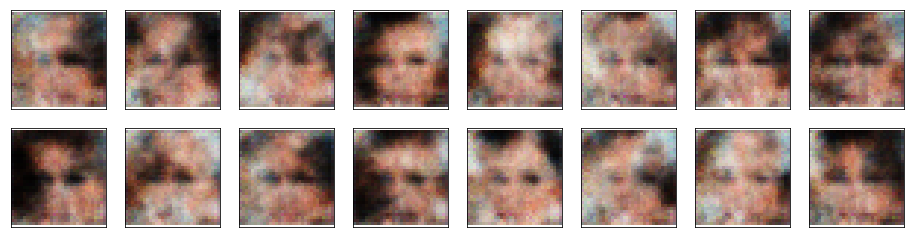

In [34]:
with open('train_samples_10sgd.pkl', 'rb') as f:
    checkpoint = pkl.load(f)
_ = view_samples(-1, checkpoint['samples'])

### With deeper network

Observations:
- There were several (7) points where the Generator loss went below that from the Discriminator, indicating that the Generator learnt a key feature that was able to "fool" the Discriminator. The generated faces were also rather realistic, capturing additional features like face contours and hair.
- Same pattern as above was observed - results did not necessarily get better beyond 20 epochs or so.

<table><tr>
<td> <p style="text-align: center;">10 epochs <img src='assets/v2_10epochs_loss.JPG' alt="Drawing" width=100%/> </td>
<td> <p style="text-align: center;">40 epochs <img src='assets/v2_40epochs_loss.JPG' alt="Drawing" width=100%/> </td>
</tr></table>

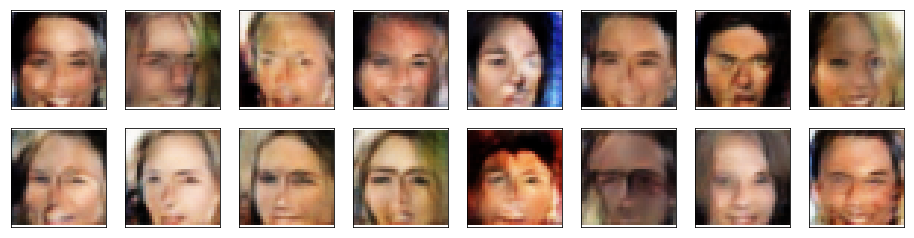

In [35]:
with open('train_samples_10deep.pkl', 'rb') as f:
    checkpoint = pkl.load(f)
_ = view_samples(-1, checkpoint['samples'])

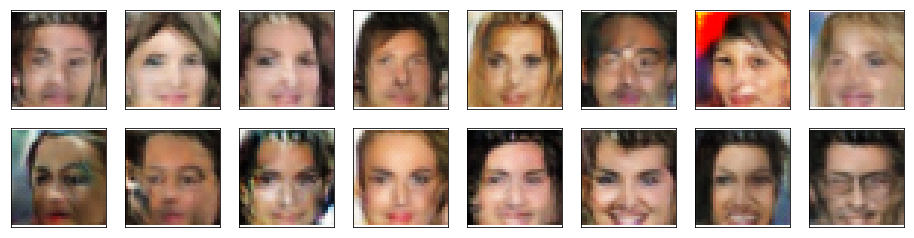

In [4]:
with open('train_samples_40deep.pkl', 'rb') as f:
    checkpoint = pkl.load(f)
_ = view_samples(-1, checkpoint['samples'])

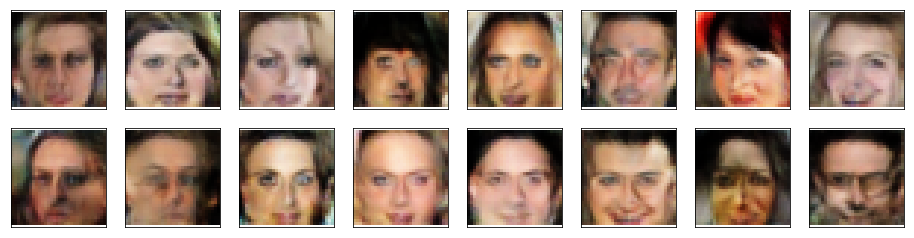

In [5]:
_ = view_samples(9, checkpoint['samples'])

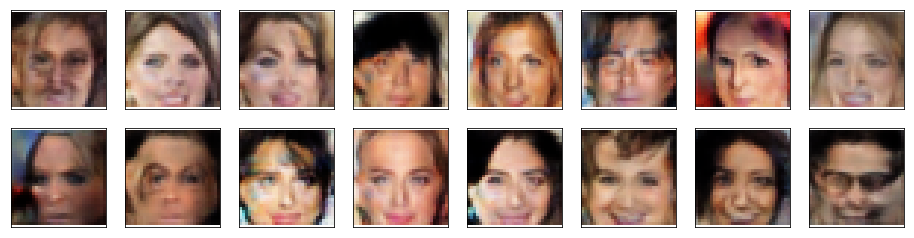

In [6]:
_ = view_samples(19, checkpoint['samples'])

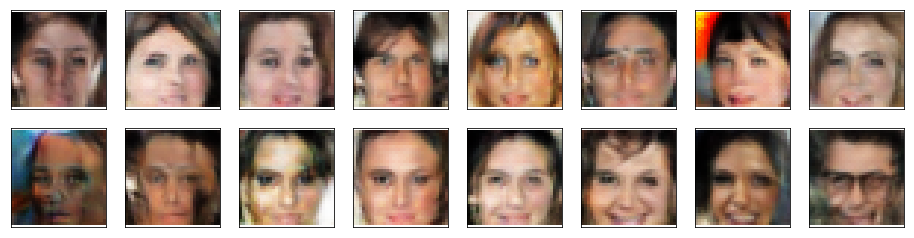

In [7]:
_ = view_samples(29, checkpoint['samples'])

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

- With the Generator and Discriminator from the DCGan workbook, key features extracted were only two eyes, a nose and a mouth. The shapes of the faces were not so accurate. The likely cause of this was that the model was unable to learn more complex features. Hence, one way to improve is to have deeper convolutional nets in the Generator and Discriminator. (Demonstrated by adding a second convolutional layer in the conv/deconv function. Results were more realistic.)
- Most of the generated faces were white, reflecting the training data. Hence, to generate faces of other races, the dataset needs to be expanded.
- With more training epochs, the Generator (and Distriminator) learnt more key features (as indicated by the spikes in the losses). Therefore, models generated after larger number of training epochs are generally better. However, actual results varied, with some face images getting worse after 20 epochs. Generally, 30 epochs gave better results than 40 epochs.
- With the SGD Optimizer, the losses did not converge well, with the Generator loss remaining much higher than the Discriminator loss i.e. the models were not training each other well.

5 Epochs:


        Epoch [    1/    5] | d_loss: 1.4485 | g_loss: 0.7476
        Epoch [    1/    5] | d_loss: 0.5443 | g_loss: 2.4781
        Epoch [    1/    5] | d_loss: 0.3974 | g_loss: 3.4000
        Epoch [    1/    5] | d_loss: 0.5311 | g_loss: 2.7732
        Epoch [    1/    5] | d_loss: 0.4638 | g_loss: 2.6284
        Epoch [    1/    5] | d_loss: 0.4382 | g_loss: 3.2018
        Epoch [    1/    5] | d_loss: 0.5735 | g_loss: 2.2802
        Epoch [    1/    5] | d_loss: 0.7142 | g_loss: 2.3116
        Epoch [    1/    5] | d_loss: 0.6987 | g_loss: 1.9692
        Epoch [    1/    5] | d_loss: 0.7562 | g_loss: 2.5341
        Epoch [    1/    5] | d_loss: 0.6981 | g_loss: 2.0370
        Epoch [    1/    5] | d_loss: 0.8343 | g_loss: 1.2012
        Epoch [    2/    5] | d_loss: 0.8420 | g_loss: 1.5435
        Epoch [    2/    5] | d_loss: 0.8247 | g_loss: 1.6216
        Epoch [    2/    5] | d_loss: 0.9382 | g_loss: 1.0926
        Epoch [    2/    5] | d_loss: 1.0377 | g_loss: 1.5046
        Epoch [    2/    5] | d_loss: 0.9727 | g_loss: 1.4689
        Epoch [    2/    5] | d_loss: 0.9565 | g_loss: 1.5127
        Epoch [    2/    5] | d_loss: 1.1452 | g_loss: 1.0737
        Epoch [    2/    5] | d_loss: 0.9164 | g_loss: 1.7449
        Epoch [    2/    5] | d_loss: 1.1848 | g_loss: 1.1015
        Epoch [    2/    5] | d_loss: 1.1955 | g_loss: 1.0725
        Epoch [    2/    5] | d_loss: 1.2091 | g_loss: 0.9435
        Epoch [    2/    5] | d_loss: 1.0639 | g_loss: 1.0631
        Epoch [    3/    5] | d_loss: 1.1974 | g_loss: 1.9129
        Epoch [    3/    5] | d_loss: 1.1844 | g_loss: 1.3951
        Epoch [    3/    5] | d_loss: 1.1800 | g_loss: 1.3233
        Epoch [    3/    5] | d_loss: 1.1348 | g_loss: 1.2268
        Epoch [    3/    5] | d_loss: 1.2152 | g_loss: 1.0542
        Epoch [    3/    5] | d_loss: 1.1694 | g_loss: 1.0521
        Epoch [    3/    5] | d_loss: 1.1312 | g_loss: 1.1334
        Epoch [    3/    5] | d_loss: 1.1500 | g_loss: 1.1024
        Epoch [    3/    5] | d_loss: 1.0649 | g_loss: 0.8174
        Epoch [    3/    5] | d_loss: 1.1622 | g_loss: 1.0510
        Epoch [    3/    5] | d_loss: 1.1157 | g_loss: 1.3754
        Epoch [    3/    5] | d_loss: 1.3065 | g_loss: 1.0490
        Epoch [    4/    5] | d_loss: 1.2780 | g_loss: 1.1522
        Epoch [    4/    5] | d_loss: 1.0465 | g_loss: 1.1731
        Epoch [    4/    5] | d_loss: 1.0374 | g_loss: 1.1887
        Epoch [    4/    5] | d_loss: 1.3865 | g_loss: 1.3357
        Epoch [    4/    5] | d_loss: 1.0441 | g_loss: 1.0472
        Epoch [    4/    5] | d_loss: 1.0531 | g_loss: 1.1845
        Epoch [    4/    5] | d_loss: 1.1798 | g_loss: 1.1069
        Epoch [    4/    5] | d_loss: 1.3400 | g_loss: 1.2896
        Epoch [    4/    5] | d_loss: 1.0863 | g_loss: 0.9137
        Epoch [    4/    5] | d_loss: 1.0986 | g_loss: 1.1405
        Epoch [    4/    5] | d_loss: 1.1653 | g_loss: 1.0468
        Epoch [    4/    5] | d_loss: 1.0632 | g_loss: 1.3107
        Epoch [    5/    5] | d_loss: 1.1048 | g_loss: 1.3434
        Epoch [    5/    5] | d_loss: 1.1725 | g_loss: 1.3310
        Epoch [    5/    5] | d_loss: 1.2123 | g_loss: 0.6519
        Epoch [    5/    5] | d_loss: 1.0835 | g_loss: 1.2277
        Epoch [    5/    5] | d_loss: 1.0779 | g_loss: 1.1862
        Epoch [    5/    5] | d_loss: 1.0019 | g_loss: 1.2809
        Epoch [    5/    5] | d_loss: 1.1901 | g_loss: 1.3061
        Epoch [    5/    5] | d_loss: 1.0765 | g_loss: 1.0580
        Epoch [    5/    5] | d_loss: 1.2226 | g_loss: 0.8851
        Epoch [    5/    5] | d_loss: 1.0650 | g_loss: 1.1542
        Epoch [    5/    5] | d_loss: 1.0762 | g_loss: 1.1975
        Epoch [    5/    5] | d_loss: 1.1257 | g_loss: 1.1507

40 Epochs:

        Epoch [    1/   40] | d_loss: 1.4437 | g_loss: 0.7853
        Epoch [    1/   40] | d_loss: 0.5316 | g_loss: 2.4539
        Epoch [    1/   40] | d_loss: 0.5226 | g_loss: 3.6437
        Epoch [    1/   40] | d_loss: 0.5707 | g_loss: 2.3581
        Epoch [    1/   40] | d_loss: 0.5556 | g_loss: 1.9344
        Epoch [    1/   40] | d_loss: 0.6843 | g_loss: 1.5369
        Epoch [    1/   40] | d_loss: 0.7491 | g_loss: 1.7514
        Epoch [    1/   40] | d_loss: 0.8194 | g_loss: 1.9111
        Epoch [    1/   40] | d_loss: 0.9291 | g_loss: 1.1041
        Epoch [    1/   40] | d_loss: 0.9556 | g_loss: 2.0439
        Epoch [    1/   40] | d_loss: 1.5884 | g_loss: 2.2050
        Epoch [    1/   40] | d_loss: 0.9269 | g_loss: 1.9568
        Epoch [    2/   40] | d_loss: 1.0447 | g_loss: 1.0990
        Epoch [    2/   40] | d_loss: 1.0098 | g_loss: 1.1965
        Epoch [    2/   40] | d_loss: 1.0884 | g_loss: 1.2270
        Epoch [    2/   40] | d_loss: 1.0562 | g_loss: 1.4169
        Epoch [    2/   40] | d_loss: 1.2210 | g_loss: 1.1492
        Epoch [    2/   40] | d_loss: 1.1594 | g_loss: 1.3433
        Epoch [    2/   40] | d_loss: 1.1562 | g_loss: 1.4181
        Epoch [    2/   40] | d_loss: 1.1320 | g_loss: 1.3965
        Epoch [    2/   40] | d_loss: 1.1326 | g_loss: 1.1172
        Epoch [    2/   40] | d_loss: 1.1306 | g_loss: 1.1427
        Epoch [    2/   40] | d_loss: 1.3519 | g_loss: 0.7350
        Epoch [    2/   40] | d_loss: 1.2413 | g_loss: 1.4398
        Epoch [    3/   40] | d_loss: 1.1962 | g_loss: 1.0161
        Epoch [    3/   40] | d_loss: 1.2311 | g_loss: 1.3328
        Epoch [    3/   40] | d_loss: 1.5064 | g_loss: 0.6436
        Epoch [    3/   40] | d_loss: 1.2992 | g_loss: 1.0511
        Epoch [    3/   40] | d_loss: 1.1796 | g_loss: 0.9201
        Epoch [    3/   40] | d_loss: 1.1288 | g_loss: 1.2410
        Epoch [    3/   40] | d_loss: 1.1454 | g_loss: 1.0595
        Epoch [    3/   40] | d_loss: 1.1253 | g_loss: 1.1269
        Epoch [    3/   40] | d_loss: 1.1530 | g_loss: 0.9494
        Epoch [    3/   40] | d_loss: 0.9652 | g_loss: 1.4481
        Epoch [    3/   40] | d_loss: 1.2400 | g_loss: 0.8216
        Epoch [    3/   40] | d_loss: 1.3188 | g_loss: 0.7327
        Epoch [    4/   40] | d_loss: 1.2436 | g_loss: 0.7626
        Epoch [    4/   40] | d_loss: 1.3261 | g_loss: 1.0481
        Epoch [    4/   40] | d_loss: 1.0948 | g_loss: 1.2956
        Epoch [    4/   40] | d_loss: 1.1319 | g_loss: 1.0849
        Epoch [    4/   40] | d_loss: 1.0624 | g_loss: 1.1402
        Epoch [    4/   40] | d_loss: 1.1974 | g_loss: 1.1236
        Epoch [    4/   40] | d_loss: 1.1269 | g_loss: 1.1157
        Epoch [    4/   40] | d_loss: 1.1236 | g_loss: 0.8246
        Epoch [    4/   40] | d_loss: 1.1106 | g_loss: 1.3427
        Epoch [    4/   40] | d_loss: 1.1827 | g_loss: 0.9672
        Epoch [    4/   40] | d_loss: 1.1047 | g_loss: 0.8978
        Epoch [    4/   40] | d_loss: 1.2452 | g_loss: 1.2461
        Epoch [    5/   40] | d_loss: 1.1400 | g_loss: 1.0618
        Epoch [    5/   40] | d_loss: 0.8823 | g_loss: 1.3631
        Epoch [    5/   40] | d_loss: 1.0816 | g_loss: 1.1031
        Epoch [    5/   40] | d_loss: 1.2606 | g_loss: 1.7694
        Epoch [    5/   40] | d_loss: 1.1889 | g_loss: 1.6161
        Epoch [    5/   40] | d_loss: 1.2010 | g_loss: 1.3857
        Epoch [    5/   40] | d_loss: 1.1101 | g_loss: 0.9498
        Epoch [    5/   40] | d_loss: 1.1352 | g_loss: 1.0568
        Epoch [    5/   40] | d_loss: 1.0806 | g_loss: 0.8654
        Epoch [    5/   40] | d_loss: 1.3129 | g_loss: 1.5207
        Epoch [    5/   40] | d_loss: 1.0876 | g_loss: 1.3631
        Epoch [    5/   40] | d_loss: 1.2378 | g_loss: 1.1922
        Epoch [    6/   40] | d_loss: 1.2494 | g_loss: 1.4583
        Epoch [    6/   40] | d_loss: 0.9431 | g_loss: 1.2572
        Epoch [    6/   40] | d_loss: 1.2460 | g_loss: 1.6531
        Epoch [    6/   40] | d_loss: 1.1991 | g_loss: 1.0427
        Epoch [    6/   40] | d_loss: 1.0898 | g_loss: 1.0691
        Epoch [    6/   40] | d_loss: 1.3585 | g_loss: 1.5189
        Epoch [    6/   40] | d_loss: 1.1675 | g_loss: 1.0615
        Epoch [    6/   40] | d_loss: 0.9814 | g_loss: 1.1731
        Epoch [    6/   40] | d_loss: 1.1609 | g_loss: 1.1717
        Epoch [    6/   40] | d_loss: 1.2646 | g_loss: 0.7071
        Epoch [    6/   40] | d_loss: 1.1141 | g_loss: 0.9236
        Epoch [    6/   40] | d_loss: 1.1230 | g_loss: 0.9041
        Epoch [    7/   40] | d_loss: 1.2551 | g_loss: 0.6221
        Epoch [    7/   40] | d_loss: 1.1027 | g_loss: 1.2331
        Epoch [    7/   40] | d_loss: 0.9638 | g_loss: 1.4572
        Epoch [    7/   40] | d_loss: 1.2937 | g_loss: 2.0406
        Epoch [    7/   40] | d_loss: 1.0854 | g_loss: 1.0127
        Epoch [    7/   40] | d_loss: 0.9980 | g_loss: 1.3740
        Epoch [    7/   40] | d_loss: 1.1325 | g_loss: 1.7100
        Epoch [    7/   40] | d_loss: 1.0918 | g_loss: 1.1289
        Epoch [    7/   40] | d_loss: 1.1116 | g_loss: 0.9040
        Epoch [    7/   40] | d_loss: 1.2120 | g_loss: 0.7014
        Epoch [    7/   40] | d_loss: 1.0346 | g_loss: 1.4416
        Epoch [    7/   40] | d_loss: 1.1271 | g_loss: 1.1680
        Epoch [    8/   40] | d_loss: 1.0663 | g_loss: 1.1093
        Epoch [    8/   40] | d_loss: 1.1884 | g_loss: 1.6226
        Epoch [    8/   40] | d_loss: 1.1033 | g_loss: 1.1217
        Epoch [    8/   40] | d_loss: 1.1055 | g_loss: 1.1088
        Epoch [    8/   40] | d_loss: 1.1387 | g_loss: 1.3459
        Epoch [    8/   40] | d_loss: 1.2124 | g_loss: 0.9454
        Epoch [    8/   40] | d_loss: 1.0488 | g_loss: 0.8646
        Epoch [    8/   40] | d_loss: 1.0059 | g_loss: 1.3018
        Epoch [    8/   40] | d_loss: 1.0027 | g_loss: 1.3040
        Epoch [    8/   40] | d_loss: 1.0126 | g_loss: 1.0697
        Epoch [    8/   40] | d_loss: 1.0017 | g_loss: 1.1334
        Epoch [    8/   40] | d_loss: 1.1642 | g_loss: 1.9615
        Epoch [    9/   40] | d_loss: 1.0892 | g_loss: 1.6003
        Epoch [    9/   40] | d_loss: 1.0288 | g_loss: 1.3057
        Epoch [    9/   40] | d_loss: 1.1047 | g_loss: 1.5156
        Epoch [    9/   40] | d_loss: 0.9645 | g_loss: 1.1373
        Epoch [    9/   40] | d_loss: 0.9674 | g_loss: 1.3400
        Epoch [    9/   40] | d_loss: 1.1264 | g_loss: 0.9834
        Epoch [    9/   40] | d_loss: 1.0941 | g_loss: 1.1722
        Epoch [    9/   40] | d_loss: 0.9656 | g_loss: 1.1273
        Epoch [    9/   40] | d_loss: 1.0058 | g_loss: 1.2084
        Epoch [    9/   40] | d_loss: 1.0573 | g_loss: 1.1283
        Epoch [    9/   40] | d_loss: 1.0648 | g_loss: 1.1319
        Epoch [    9/   40] | d_loss: 1.0062 | g_loss: 1.1917
        Epoch [   10/   40] | d_loss: 1.0657 | g_loss: 1.5667
        Epoch [   10/   40] | d_loss: 0.9681 | g_loss: 1.3432
        Epoch [   10/   40] | d_loss: 1.2118 | g_loss: 1.3461
        Epoch [   10/   40] | d_loss: 1.0651 | g_loss: 1.1128
        Epoch [   10/   40] | d_loss: 0.8572 | g_loss: 1.4532
        Epoch [   10/   40] | d_loss: 0.9836 | g_loss: 0.9646
        Epoch [   10/   40] | d_loss: 1.0337 | g_loss: 0.8138
        Epoch [   10/   40] | d_loss: 1.0353 | g_loss: 1.3482
        Epoch [   10/   40] | d_loss: 1.0023 | g_loss: 1.5404
        Epoch [   10/   40] | d_loss: 1.0098 | g_loss: 1.8561
        Epoch [   10/   40] | d_loss: 1.0046 | g_loss: 1.3656
        Epoch [   10/   40] | d_loss: 1.0874 | g_loss: 1.5384
        Epoch [   11/   40] | d_loss: 1.1841 | g_loss: 0.9807
        Epoch [   11/   40] | d_loss: 0.9435 | g_loss: 1.5412
        Epoch [   11/   40] | d_loss: 1.4898 | g_loss: 0.6664
        Epoch [   11/   40] | d_loss: 1.1008 | g_loss: 1.1282
        Epoch [   11/   40] | d_loss: 0.9681 | g_loss: 0.9860
        Epoch [   11/   40] | d_loss: 1.0189 | g_loss: 1.5144
        Epoch [   11/   40] | d_loss: 0.9786 | g_loss: 1.1448
        Epoch [   11/   40] | d_loss: 1.0669 | g_loss: 0.8328
        Epoch [   11/   40] | d_loss: 1.0816 | g_loss: 1.1186
        Epoch [   11/   40] | d_loss: 1.1095 | g_loss: 0.9236
        Epoch [   11/   40] | d_loss: 1.0452 | g_loss: 1.1694
        Epoch [   11/   40] | d_loss: 1.0793 | g_loss: 1.0114
        Epoch [   12/   40] | d_loss: 1.1021 | g_loss: 0.7739
        Epoch [   12/   40] | d_loss: 0.9935 | g_loss: 1.6943
        Epoch [   12/   40] | d_loss: 1.0365 | g_loss: 1.2693
        Epoch [   12/   40] | d_loss: 1.0710 | g_loss: 1.1770
        Epoch [   12/   40] | d_loss: 1.1204 | g_loss: 1.6759
        Epoch [   12/   40] | d_loss: 1.0449 | g_loss: 1.3377
        Epoch [   12/   40] | d_loss: 0.9927 | g_loss: 1.4142
        Epoch [   12/   40] | d_loss: 1.9553 | g_loss: 2.8975
        Epoch [   12/   40] | d_loss: 1.0855 | g_loss: 1.0535
        Epoch [   12/   40] | d_loss: 1.3754 | g_loss: 1.5387
        Epoch [   12/   40] | d_loss: 0.9554 | g_loss: 1.1541
        Epoch [   12/   40] | d_loss: 0.9578 | g_loss: 1.2051
        Epoch [   13/   40] | d_loss: 1.0935 | g_loss: 1.7234
        Epoch [   13/   40] | d_loss: 1.1097 | g_loss: 1.6237
        Epoch [   13/   40] | d_loss: 0.8873 | g_loss: 1.5808
        Epoch [   13/   40] | d_loss: 1.4229 | g_loss: 1.9438
        Epoch [   13/   40] | d_loss: 1.0255 | g_loss: 1.1911
        Epoch [   13/   40] | d_loss: 0.8935 | g_loss: 0.9522
        Epoch [   13/   40] | d_loss: 1.0156 | g_loss: 1.3206
        Epoch [   13/   40] | d_loss: 1.0137 | g_loss: 2.0596
        Epoch [   13/   40] | d_loss: 1.0983 | g_loss: 1.0816
        Epoch [   13/   40] | d_loss: 1.0746 | g_loss: 1.8221
        Epoch [   13/   40] | d_loss: 1.0690 | g_loss: 1.4381
        Epoch [   13/   40] | d_loss: 1.3115 | g_loss: 1.5295
        Epoch [   14/   40] | d_loss: 1.1200 | g_loss: 0.8473
        Epoch [   14/   40] | d_loss: 1.0334 | g_loss: 1.3110
        Epoch [   14/   40] | d_loss: 1.0134 | g_loss: 1.6473
        Epoch [   14/   40] | d_loss: 1.0869 | g_loss: 1.7738
        Epoch [   14/   40] | d_loss: 0.9972 | g_loss: 1.2065
        Epoch [   14/   40] | d_loss: 1.0324 | g_loss: 1.4461
        Epoch [   14/   40] | d_loss: 0.9485 | g_loss: 1.4798
        Epoch [   14/   40] | d_loss: 0.9825 | g_loss: 1.3595
        Epoch [   14/   40] | d_loss: 0.9882 | g_loss: 0.9737
        Epoch [   14/   40] | d_loss: 0.8715 | g_loss: 1.3675
        Epoch [   14/   40] | d_loss: 0.9751 | g_loss: 1.3222
        Epoch [   14/   40] | d_loss: 0.9924 | g_loss: 1.6603
        Epoch [   15/   40] | d_loss: 1.1588 | g_loss: 2.0769
        Epoch [   15/   40] | d_loss: 0.9304 | g_loss: 1.1939
        Epoch [   15/   40] | d_loss: 1.0881 | g_loss: 1.0542
        Epoch [   15/   40] | d_loss: 0.9247 | g_loss: 1.5165
        Epoch [   15/   40] | d_loss: 1.0101 | g_loss: 1.0756
        Epoch [   15/   40] | d_loss: 0.9237 | g_loss: 1.4529
        Epoch [   15/   40] | d_loss: 1.0671 | g_loss: 1.1717
        Epoch [   15/   40] | d_loss: 1.0081 | g_loss: 1.0990
        Epoch [   15/   40] | d_loss: 1.1122 | g_loss: 0.9843
        Epoch [   15/   40] | d_loss: 0.9669 | g_loss: 1.2075
        Epoch [   15/   40] | d_loss: 0.8931 | g_loss: 1.0969
        Epoch [   15/   40] | d_loss: 0.9175 | g_loss: 1.3713
        Epoch [   16/   40] | d_loss: 0.8980 | g_loss: 1.1356
        Epoch [   16/   40] | d_loss: 0.9937 | g_loss: 1.1205
        Epoch [   16/   40] | d_loss: 1.2615 | g_loss: 0.9968
        Epoch [   16/   40] | d_loss: 1.1247 | g_loss: 0.9399
        Epoch [   16/   40] | d_loss: 1.0076 | g_loss: 1.2050
        Epoch [   16/   40] | d_loss: 0.8876 | g_loss: 1.5757
        Epoch [   16/   40] | d_loss: 1.0079 | g_loss: 1.2462
        Epoch [   16/   40] | d_loss: 1.0171 | g_loss: 1.2937
        Epoch [   16/   40] | d_loss: 0.9306 | g_loss: 1.2547
        Epoch [   16/   40] | d_loss: 1.0960 | g_loss: 0.9578
        Epoch [   16/   40] | d_loss: 0.7759 | g_loss: 1.1022
        Epoch [   16/   40] | d_loss: 0.9629 | g_loss: 1.7705
        Epoch [   17/   40] | d_loss: 1.0971 | g_loss: 1.2553
        Epoch [   17/   40] | d_loss: 0.9150 | g_loss: 1.4098
        Epoch [   17/   40] | d_loss: 1.0527 | g_loss: 1.7278
        Epoch [   17/   40] | d_loss: 1.1166 | g_loss: 1.1418
        Epoch [   17/   40] | d_loss: 0.9324 | g_loss: 1.0446
        Epoch [   17/   40] | d_loss: 0.9158 | g_loss: 1.4486
        Epoch [   17/   40] | d_loss: 0.9510 | g_loss: 1.2973
        Epoch [   17/   40] | d_loss: 0.9323 | g_loss: 1.5732
        Epoch [   17/   40] | d_loss: 1.0362 | g_loss: 1.1223
        Epoch [   17/   40] | d_loss: 0.8692 | g_loss: 1.3222
        Epoch [   17/   40] | d_loss: 0.9637 | g_loss: 1.1975
        Epoch [   17/   40] | d_loss: 0.9626 | g_loss: 1.2999
        Epoch [   18/   40] | d_loss: 0.8751 | g_loss: 1.4855
        Epoch [   18/   40] | d_loss: 0.9821 | g_loss: 1.3001
        Epoch [   18/   40] | d_loss: 0.8010 | g_loss: 1.4171
        Epoch [   18/   40] | d_loss: 0.9592 | g_loss: 1.8766
        Epoch [   18/   40] | d_loss: 0.8640 | g_loss: 1.7985
        Epoch [   18/   40] | d_loss: 0.9217 | g_loss: 1.3255
        Epoch [   18/   40] | d_loss: 1.1170 | g_loss: 1.8917
        Epoch [   18/   40] | d_loss: 0.8419 | g_loss: 1.6729
        Epoch [   18/   40] | d_loss: 0.9330 | g_loss: 1.5152
        Epoch [   18/   40] | d_loss: 1.4543 | g_loss: 0.7781
        Epoch [   18/   40] | d_loss: 0.8794 | g_loss: 1.2609
        Epoch [   18/   40] | d_loss: 0.9039 | g_loss: 1.3563
        Epoch [   19/   40] | d_loss: 0.9410 | g_loss: 1.2743
        Epoch [   19/   40] | d_loss: 0.7818 | g_loss: 1.6963
        Epoch [   19/   40] | d_loss: 1.2455 | g_loss: 1.8716
        Epoch [   19/   40] | d_loss: 0.8865 | g_loss: 1.5596
        Epoch [   19/   40] | d_loss: 1.1031 | g_loss: 2.5402
        Epoch [   19/   40] | d_loss: 0.8850 | g_loss: 1.2563
        Epoch [   19/   40] | d_loss: 0.9058 | g_loss: 1.2883
        Epoch [   19/   40] | d_loss: 1.0447 | g_loss: 0.8600
        Epoch [   19/   40] | d_loss: 0.9595 | g_loss: 1.8755
        Epoch [   19/   40] | d_loss: 0.8310 | g_loss: 1.2699
        Epoch [   19/   40] | d_loss: 0.9468 | g_loss: 1.6635
        Epoch [   19/   40] | d_loss: 0.9988 | g_loss: 2.5203
        Epoch [   20/   40] | d_loss: 0.8526 | g_loss: 1.4967
        Epoch [   20/   40] | d_loss: 0.8845 | g_loss: 1.1242
        Epoch [   20/   40] | d_loss: 0.9125 | g_loss: 1.4296
        Epoch [   20/   40] | d_loss: 1.0120 | g_loss: 2.2568
        Epoch [   20/   40] | d_loss: 0.9111 | g_loss: 1.3608
        Epoch [   20/   40] | d_loss: 0.9177 | g_loss: 1.1579
        Epoch [   20/   40] | d_loss: 0.8451 | g_loss: 0.9660
        Epoch [   20/   40] | d_loss: 0.8486 | g_loss: 1.5901
        Epoch [   20/   40] | d_loss: 0.8902 | g_loss: 1.7491
        Epoch [   20/   40] | d_loss: 1.0136 | g_loss: 1.6260
        Epoch [   20/   40] | d_loss: 1.0600 | g_loss: 1.3447
        Epoch [   20/   40] | d_loss: 0.8781 | g_loss: 1.0520
        Epoch [   21/   40] | d_loss: 0.8655 | g_loss: 1.6144
        Epoch [   21/   40] | d_loss: 1.8305 | g_loss: 0.6664
        Epoch [   21/   40] | d_loss: 0.8429 | g_loss: 1.5574
        Epoch [   21/   40] | d_loss: 0.8860 | g_loss: 2.0536
        Epoch [   21/   40] | d_loss: 0.8585 | g_loss: 1.0985
        Epoch [   21/   40] | d_loss: 1.2495 | g_loss: 3.1934
        Epoch [   21/   40] | d_loss: 0.9267 | g_loss: 1.5074
        Epoch [   21/   40] | d_loss: 0.8579 | g_loss: 2.0641
        Epoch [   21/   40] | d_loss: 0.6975 | g_loss: 1.6487
        Epoch [   21/   40] | d_loss: 0.8173 | g_loss: 1.8169
        Epoch [   21/   40] | d_loss: 0.9939 | g_loss: 2.3473
        Epoch [   21/   40] | d_loss: 0.8845 | g_loss: 1.3825
        Epoch [   22/   40] | d_loss: 1.3236 | g_loss: 1.4775
        Epoch [   22/   40] | d_loss: 0.9002 | g_loss: 1.8327
        Epoch [   22/   40] | d_loss: 1.0159 | g_loss: 1.5148
        Epoch [   22/   40] | d_loss: 0.9066 | g_loss: 1.5263
        Epoch [   22/   40] | d_loss: 0.8517 | g_loss: 1.5270
        Epoch [   22/   40] | d_loss: 0.9405 | g_loss: 2.1040
        Epoch [   22/   40] | d_loss: 0.8768 | g_loss: 1.3524
        Epoch [   22/   40] | d_loss: 0.8923 | g_loss: 1.5568
        Epoch [   22/   40] | d_loss: 0.8203 | g_loss: 1.2177
        Epoch [   22/   40] | d_loss: 0.7715 | g_loss: 1.5599
        Epoch [   22/   40] | d_loss: 0.8811 | g_loss: 0.9676
        Epoch [   22/   40] | d_loss: 0.8480 | g_loss: 1.8151
        Epoch [   23/   40] | d_loss: 1.8096 | g_loss: 2.7114
        Epoch [   23/   40] | d_loss: 0.8404 | g_loss: 1.8989
        Epoch [   23/   40] | d_loss: 0.9047 | g_loss: 1.7434
        Epoch [   23/   40] | d_loss: 0.8093 | g_loss: 1.4729
        Epoch [   23/   40] | d_loss: 0.9531 | g_loss: 1.1355
        Epoch [   23/   40] | d_loss: 1.5264 | g_loss: 0.8206
        Epoch [   23/   40] | d_loss: 0.8766 | g_loss: 1.3213
        Epoch [   23/   40] | d_loss: 0.9591 | g_loss: 1.8977
        Epoch [   23/   40] | d_loss: 0.8442 | g_loss: 1.6247
        Epoch [   23/   40] | d_loss: 0.8624 | g_loss: 1.2085
        Epoch [   23/   40] | d_loss: 0.6590 | g_loss: 1.5449
        Epoch [   23/   40] | d_loss: 0.8063 | g_loss: 1.4296
        Epoch [   24/   40] | d_loss: 0.7851 | g_loss: 1.5887
        Epoch [   24/   40] | d_loss: 0.8274 | g_loss: 1.4033
        Epoch [   24/   40] | d_loss: 0.8497 | g_loss: 1.4409
        Epoch [   24/   40] | d_loss: 0.7638 | g_loss: 1.3254
        Epoch [   24/   40] | d_loss: 0.9481 | g_loss: 0.9407
        Epoch [   24/   40] | d_loss: 0.7295 | g_loss: 1.4627
        Epoch [   24/   40] | d_loss: 0.8720 | g_loss: 1.4802
        Epoch [   24/   40] | d_loss: 0.6738 | g_loss: 1.6088
        Epoch [   24/   40] | d_loss: 0.7878 | g_loss: 1.3862
        Epoch [   24/   40] | d_loss: 0.7818 | g_loss: 1.8986
        Epoch [   24/   40] | d_loss: 0.6865 | g_loss: 1.6420
        Epoch [   24/   40] | d_loss: 0.7678 | g_loss: 2.4802
        Epoch [   25/   40] | d_loss: 0.6781 | g_loss: 1.9960
        Epoch [   25/   40] | d_loss: 0.7704 | g_loss: 1.5569
        Epoch [   25/   40] | d_loss: 0.7369 | g_loss: 1.2493
        Epoch [   25/   40] | d_loss: 0.8104 | g_loss: 1.4925
        Epoch [   25/   40] | d_loss: 0.9278 | g_loss: 0.9438
        Epoch [   25/   40] | d_loss: 0.9410 | g_loss: 1.1326
        Epoch [   25/   40] | d_loss: 1.1998 | g_loss: 2.7956
        Epoch [   25/   40] | d_loss: 0.8056 | g_loss: 1.5189
        Epoch [   25/   40] | d_loss: 0.7245 | g_loss: 1.6729
        Epoch [   25/   40] | d_loss: 0.6921 | g_loss: 2.1269
        Epoch [   25/   40] | d_loss: 1.6875 | g_loss: 1.2995
        Epoch [   25/   40] | d_loss: 0.8409 | g_loss: 1.5215
        Epoch [   26/   40] | d_loss: 0.8131 | g_loss: 1.8224
        Epoch [   26/   40] | d_loss: 0.8463 | g_loss: 1.0724
        Epoch [   26/   40] | d_loss: 0.7592 | g_loss: 1.2682
        Epoch [   26/   40] | d_loss: 0.8352 | g_loss: 2.0410
        Epoch [   26/   40] | d_loss: 0.7042 | g_loss: 1.3109
        Epoch [   26/   40] | d_loss: 0.7171 | g_loss: 1.8671
        Epoch [   26/   40] | d_loss: 0.7183 | g_loss: 1.3657
        Epoch [   26/   40] | d_loss: 0.7289 | g_loss: 1.5348
        Epoch [   26/   40] | d_loss: 0.7382 | g_loss: 1.5881
        Epoch [   26/   40] | d_loss: 0.7054 | g_loss: 1.9292
        Epoch [   26/   40] | d_loss: 0.7883 | g_loss: 1.3319
        Epoch [   26/   40] | d_loss: 0.8385 | g_loss: 1.1642
        Epoch [   27/   40] | d_loss: 0.8614 | g_loss: 1.9655
        Epoch [   27/   40] | d_loss: 0.7607 | g_loss: 1.4735
        Epoch [   27/   40] | d_loss: 0.8449 | g_loss: 2.2778
        Epoch [   27/   40] | d_loss: 0.7388 | g_loss: 2.5878
        Epoch [   27/   40] | d_loss: 0.7001 | g_loss: 1.8115
        Epoch [   27/   40] | d_loss: 0.8748 | g_loss: 1.2913
        Epoch [   27/   40] | d_loss: 0.6924 | g_loss: 1.6652
        Epoch [   27/   40] | d_loss: 0.7763 | g_loss: 1.1704
        Epoch [   27/   40] | d_loss: 0.6473 | g_loss: 2.0102
        Epoch [   27/   40] | d_loss: 0.6907 | g_loss: 2.2454
        Epoch [   27/   40] | d_loss: 0.7531 | g_loss: 1.7305
        Epoch [   27/   40] | d_loss: 0.8259 | g_loss: 1.5795
        Epoch [   28/   40] | d_loss: 0.8228 | g_loss: 1.7667
        Epoch [   28/   40] | d_loss: 0.7521 | g_loss: 1.8702
        Epoch [   28/   40] | d_loss: 0.7602 | g_loss: 2.8150
        Epoch [   28/   40] | d_loss: 0.9988 | g_loss: 2.7921
        Epoch [   28/   40] | d_loss: 0.8425 | g_loss: 1.0685
        Epoch [   28/   40] | d_loss: 0.7758 | g_loss: 2.0840
        Epoch [   28/   40] | d_loss: 0.7609 | g_loss: 2.1005
        Epoch [   28/   40] | d_loss: 0.6912 | g_loss: 1.7971
        Epoch [   28/   40] | d_loss: 0.8061 | g_loss: 2.8078
        Epoch [   28/   40] | d_loss: 4.2613 | g_loss: 5.2675
        Epoch [   28/   40] | d_loss: 0.8837 | g_loss: 1.0199
        Epoch [   28/   40] | d_loss: 0.9730 | g_loss: 0.8994
        Epoch [   29/   40] | d_loss: 0.7947 | g_loss: 1.1079
        Epoch [   29/   40] | d_loss: 0.7307 | g_loss: 1.8042
        Epoch [   29/   40] | d_loss: 0.6991 | g_loss: 1.8864
        Epoch [   29/   40] | d_loss: 1.7509 | g_loss: 2.4276
        Epoch [   29/   40] | d_loss: 0.7995 | g_loss: 1.6674
        Epoch [   29/   40] | d_loss: 0.8556 | g_loss: 1.0851
        Epoch [   29/   40] | d_loss: 1.6917 | g_loss: 3.1924
        Epoch [   29/   40] | d_loss: 0.6525 | g_loss: 1.9917
        Epoch [   29/   40] | d_loss: 0.6324 | g_loss: 1.7090
        Epoch [   29/   40] | d_loss: 0.8746 | g_loss: 2.1518
        Epoch [   29/   40] | d_loss: 0.7193 | g_loss: 2.0210
        Epoch [   29/   40] | d_loss: 0.8298 | g_loss: 1.0025
        Epoch [   30/   40] | d_loss: 0.8006 | g_loss: 1.5953
        Epoch [   30/   40] | d_loss: 0.7079 | g_loss: 1.6935
        Epoch [   30/   40] | d_loss: 0.7353 | g_loss: 2.3880
        Epoch [   30/   40] | d_loss: 0.6924 | g_loss: 1.9314
        Epoch [   30/   40] | d_loss: 0.6852 | g_loss: 2.0490
        Epoch [   30/   40] | d_loss: 0.6285 | g_loss: 2.2556
        Epoch [   30/   40] | d_loss: 0.8234 | g_loss: 1.8801
        Epoch [   30/   40] | d_loss: 0.6193 | g_loss: 2.5495
        Epoch [   30/   40] | d_loss: 0.6148 | g_loss: 2.2814
        Epoch [   30/   40] | d_loss: 0.8888 | g_loss: 0.9248
        Epoch [   30/   40] | d_loss: 0.7885 | g_loss: 1.9908
        Epoch [   31/   40] | d_loss: 0.8226 | g_loss: 1.2619
        Epoch [   31/   40] | d_loss: 0.7677 | g_loss: 1.3273
        Epoch [   31/   40] | d_loss: 0.7677 | g_loss: 1.5138
        Epoch [   31/   40] | d_loss: 0.6849 | g_loss: 1.5192
        Epoch [   31/   40] | d_loss: 0.5873 | g_loss: 1.7149
        Epoch [   31/   40] | d_loss: 0.5860 | g_loss: 1.9504
        Epoch [   31/   40] | d_loss: 0.6238 | g_loss: 1.8029
        Epoch [   31/   40] | d_loss: 0.7945 | g_loss: 1.3661
        Epoch [   31/   40] | d_loss: 0.6279 | g_loss: 2.0036
        Epoch [   31/   40] | d_loss: 0.6364 | g_loss: 1.7425
        Epoch [   32/   40] | d_loss: 0.7017 | g_loss: 1.7003
        Epoch [   32/   40] | d_loss: 0.8014 | g_loss: 1.4469
        Epoch [   32/   40] | d_loss: 0.6360 | g_loss: 1.8855
        Epoch [   32/   40] | d_loss: 0.6129 | g_loss: 0.8783
        Epoch [   32/   40] | d_loss: 0.6474 | g_loss: 1.7426
        Epoch [   32/   40] | d_loss: 0.6289 | g_loss: 2.2710
        Epoch [   32/   40] | d_loss: 0.6504 | g_loss: 1.6013
        Epoch [   32/   40] | d_loss: 0.6395 | g_loss: 1.7981
        Epoch [   32/   40] | d_loss: 2.1908 | g_loss: 5.1134
        Epoch [   32/   40] | d_loss: 0.7061 | g_loss: 2.1597
        Epoch [   32/   40] | d_loss: 0.6315 | g_loss: 2.4855
        Epoch [   32/   40] | d_loss: 0.9240 | g_loss: 2.3264
        Epoch [   33/   40] | d_loss: 0.6718 | g_loss: 1.6518
        Epoch [   33/   40] | d_loss: 0.6404 | g_loss: 1.6777
        Epoch [   33/   40] | d_loss: 1.0560 | g_loss: 3.1648
        Epoch [   33/   40] | d_loss: 0.5565 | g_loss: 1.9637
        Epoch [   33/   40] | d_loss: 0.6036 | g_loss: 1.5148
        Epoch [   33/   40] | d_loss: 1.3760 | g_loss: 0.6794
        Epoch [   33/   40] | d_loss: 0.6106 | g_loss: 1.9400
        Epoch [   33/   40] | d_loss: 1.3639 | g_loss: 3.1632
        Epoch [   33/   40] | d_loss: 0.8267 | g_loss: 1.1380
        Epoch [   33/   40] | d_loss: 0.5953 | g_loss: 2.2781
        Epoch [   33/   40] | d_loss: 0.6558 | g_loss: 1.8078
        Epoch [   33/   40] | d_loss: 0.5749 | g_loss: 2.4429
        Epoch [   34/   40] | d_loss: 0.8907 | g_loss: 0.9178
        Epoch [   34/   40] | d_loss: 0.6653 | g_loss: 2.4587
        Epoch [   34/   40] | d_loss: 1.2860 | g_loss: 2.6236
        Epoch [   34/   40] | d_loss: 0.6661 | g_loss: 1.7466
        Epoch [   34/   40] | d_loss: 0.6188 | g_loss: 1.8979
        Epoch [   34/   40] | d_loss: 0.6142 | g_loss: 2.1095
        Epoch [   34/   40] | d_loss: 0.7519 | g_loss: 2.0455
        Epoch [   34/   40] | d_loss: 0.6481 | g_loss: 2.4052
        Epoch [   34/   40] | d_loss: 0.6967 | g_loss: 2.3582
        Epoch [   34/   40] | d_loss: 0.6477 | g_loss: 2.0572
        Epoch [   34/   40] | d_loss: 1.2779 | g_loss: 1.7618
        Epoch [   34/   40] | d_loss: 0.7171 | g_loss: 2.4055
        Epoch [   35/   40] | d_loss: 0.5966 | g_loss: 2.3815
        Epoch [   35/   40] | d_loss: 0.7073 | g_loss: 1.7322
        Epoch [   35/   40] | d_loss: 0.7230 | g_loss: 1.3755
        Epoch [   35/   40] | d_loss: 0.6653 | g_loss: 2.4625
        Epoch [   35/   40] | d_loss: 0.7043 | g_loss: 2.3504
        Epoch [   35/   40] | d_loss: 1.8685 | g_loss: 2.3097
        Epoch [   35/   40] | d_loss: 0.7135 | g_loss: 1.4169
        Epoch [   35/   40] | d_loss: 0.6216 | g_loss: 1.7287
        Epoch [   35/   40] | d_loss: 0.8759 | g_loss: 1.0057
        Epoch [   35/   40] | d_loss: 0.6437 | g_loss: 1.7559
        Epoch [   35/   40] | d_loss: 1.0867 | g_loss: 0.7750
        Epoch [   35/   40] | d_loss: 0.7214 | g_loss: 1.4982
        Epoch [   36/   40] | d_loss: 0.6092 | g_loss: 1.9253
        Epoch [   36/   40] | d_loss: 0.7657 | g_loss: 1.3189
        Epoch [   36/   40] | d_loss: 0.5849 | g_loss: 1.9290
        Epoch [   36/   40] | d_loss: 0.6350 | g_loss: 2.2775
        Epoch [   36/   40] | d_loss: 0.5601 | g_loss: 1.5764
        Epoch [   36/   40] | d_loss: 0.7107 | g_loss: 1.8565
        Epoch [   36/   40] | d_loss: 0.7049 | g_loss: 1.8748
        Epoch [   36/   40] | d_loss: 0.6004 | g_loss: 1.9964
        Epoch [   36/   40] | d_loss: 1.2212 | g_loss: 1.1260
        Epoch [   36/   40] | d_loss: 0.7625 | g_loss: 1.5873
        Epoch [   36/   40] | d_loss: 0.6417 | g_loss: 1.9512
        Epoch [   36/   40] | d_loss: 0.5769 | g_loss: 1.8678
        Epoch [   37/   40] | d_loss: 0.5833 | g_loss: 2.3045
        Epoch [   37/   40] | d_loss: 1.3609 | g_loss: 3.4724
        Epoch [   37/   40] | d_loss: 0.7838 | g_loss: 2.4073
        Epoch [   37/   40] | d_loss: 0.7285 | g_loss: 2.1029
        Epoch [   37/   40] | d_loss: 0.7462 | g_loss: 1.5299
        Epoch [   37/   40] | d_loss: 0.5453 | g_loss: 2.0318
        Epoch [   37/   40] | d_loss: 0.5871 | g_loss: 2.6495
        Epoch [   37/   40] | d_loss: 0.6589 | g_loss: 1.7222
        Epoch [   37/   40] | d_loss: 0.5396 | g_loss: 2.5599
        Epoch [   37/   40] | d_loss: 0.5628 | g_loss: 2.5289
        Epoch [   37/   40] | d_loss: 0.9011 | g_loss: 1.2542
        Epoch [   37/   40] | d_loss: 0.6905 | g_loss: 2.4359
        Epoch [   38/   40] | d_loss: 0.6353 | g_loss: 2.1318
        Epoch [   38/   40] | d_loss: 0.5813 | g_loss: 1.9171
        Epoch [   38/   40] | d_loss: 0.6194 | g_loss: 2.0694
        Epoch [   38/   40] | d_loss: 0.5984 | g_loss: 1.9599
        Epoch [   38/   40] | d_loss: 1.1062 | g_loss: 0.5823
        Epoch [   38/   40] | d_loss: 0.5687 | g_loss: 2.3804
        Epoch [   38/   40] | d_loss: 0.5611 | g_loss: 2.0157
        Epoch [   38/   40] | d_loss: 0.7031 | g_loss: 2.8433
        Epoch [   38/   40] | d_loss: 0.5496 | g_loss: 2.1010
        Epoch [   38/   40] | d_loss: 0.5714 | g_loss: 2.4561
        Epoch [   38/   40] | d_loss: 0.6832 | g_loss: 1.8626
        Epoch [   38/   40] | d_loss: 0.6528 | g_loss: 1.9944
        Epoch [   39/   40] | d_loss: 0.8287 | g_loss: 0.9481
        Epoch [   39/   40] | d_loss: 0.5919 | g_loss: 2.6288
        Epoch [   39/   40] | d_loss: 0.8148 | g_loss: 1.6144
        Epoch [   39/   40] | d_loss: 0.5922 | g_loss: 1.6119
        Epoch [   39/   40] | d_loss: 0.6412 | g_loss: 2.0118
        Epoch [   39/   40] | d_loss: 0.5433 | g_loss: 2.3265
        Epoch [   39/   40] | d_loss: 0.5027 | g_loss: 2.4729
        Epoch [   39/   40] | d_loss: 0.6018 | g_loss: 2.5043
        Epoch [   39/   40] | d_loss: 0.5502 | g_loss: 1.7866
        Epoch [   39/   40] | d_loss: 0.5719 | g_loss: 2.0206
        Epoch [   39/   40] | d_loss: 0.5801 | g_loss: 2.3983
        Epoch [   39/   40] | d_loss: 0.5859 | g_loss: 1.9534
        Epoch [   40/   40] | d_loss: 0.5582 | g_loss: 2.4504
        Epoch [   40/   40] | d_loss: 0.4635 | g_loss: 2.3002
        Epoch [   40/   40] | d_loss: 0.9539 | g_loss: 3.4821
        Epoch [   40/   40] | d_loss: 0.8442 | g_loss: 1.3225
        Epoch [   40/   40] | d_loss: 0.5670 | g_loss: 2.4603
        Epoch [   40/   40] | d_loss: 0.6816 | g_loss: 2.2660
        Epoch [   40/   40] | d_loss: 0.6025 | g_loss: 2.3178
        Epoch [   40/   40] | d_loss: 0.5927 | g_loss: 1.6300
        Epoch [   40/   40] | d_loss: 0.5930 | g_loss: 3.0354
        Epoch [   40/   40] | d_loss: 0.5254 | g_loss: 2.7679
        Epoch [   40/   40] | d_loss: 0.8422 | g_loss: 1.0762
        Epoch [   40/   40] | d_loss: 0.5828 | g_loss: 1.9979

10 Epochs with SGD optimizer:

        Epoch [    1/   10] | d_loss: 1.4015 | g_loss: 0.6663
        Epoch [    1/   10] | d_loss: 1.0669 | g_loss: 0.8467
        Epoch [    1/   10] | d_loss: 0.9390 | g_loss: 0.9382
        Epoch [    1/   10] | d_loss: 0.9362 | g_loss: 0.9756
        Epoch [    1/   10] | d_loss: 0.9358 | g_loss: 1.0018
        Epoch [    1/   10] | d_loss: 0.8931 | g_loss: 1.0036
        Epoch [    1/   10] | d_loss: 0.8924 | g_loss: 1.0108
        Epoch [    1/   10] | d_loss: 0.9177 | g_loss: 1.0489
        Epoch [    1/   10] | d_loss: 0.8943 | g_loss: 1.1136
        Epoch [    1/   10] | d_loss: 0.8433 | g_loss: 1.1086
        Epoch [    1/   10] | d_loss: 0.9249 | g_loss: 1.0772
        Epoch [    1/   10] | d_loss: 0.8894 | g_loss: 1.0766
        Epoch [    2/   10] | d_loss: 0.9010 | g_loss: 1.1054
        Epoch [    2/   10] | d_loss: 0.8432 | g_loss: 1.1742
        Epoch [    2/   10] | d_loss: 0.8346 | g_loss: 1.2256
        Epoch [    2/   10] | d_loss: 0.8161 | g_loss: 1.2403
        Epoch [    2/   10] | d_loss: 0.8486 | g_loss: 1.1601
        Epoch [    2/   10] | d_loss: 0.8836 | g_loss: 1.1290
        Epoch [    2/   10] | d_loss: 0.9234 | g_loss: 1.1080
        Epoch [    2/   10] | d_loss: 0.9514 | g_loss: 1.1499
        Epoch [    2/   10] | d_loss: 0.8821 | g_loss: 1.2064
        Epoch [    2/   10] | d_loss: 0.8619 | g_loss: 1.2612
        Epoch [    2/   10] | d_loss: 0.8734 | g_loss: 1.2541
        Epoch [    2/   10] | d_loss: 0.8732 | g_loss: 1.2212
        Epoch [    3/   10] | d_loss: 0.9060 | g_loss: 1.1842
        Epoch [    3/   10] | d_loss: 0.9180 | g_loss: 1.2236
        Epoch [    3/   10] | d_loss: 0.8860 | g_loss: 1.2807
        Epoch [    3/   10] | d_loss: 0.8353 | g_loss: 1.3289
        Epoch [    3/   10] | d_loss: 0.8073 | g_loss: 1.3179
        Epoch [    3/   10] | d_loss: 0.8089 | g_loss: 1.3266
        Epoch [    3/   10] | d_loss: 0.7330 | g_loss: 1.4343
        Epoch [    3/   10] | d_loss: 0.7196 | g_loss: 1.5079
        Epoch [    3/   10] | d_loss: 0.7597 | g_loss: 1.4095
        Epoch [    3/   10] | d_loss: 0.8182 | g_loss: 1.3847
        Epoch [    3/   10] | d_loss: 0.7345 | g_loss: 1.5336
        Epoch [    3/   10] | d_loss: 0.6804 | g_loss: 1.6212
        Epoch [    4/   10] | d_loss: 0.7057 | g_loss: 1.5052
        Epoch [    4/   10] | d_loss: 0.7094 | g_loss: 1.5243
        Epoch [    4/   10] | d_loss: 0.6623 | g_loss: 1.6646
        Epoch [    4/   10] | d_loss: 0.6457 | g_loss: 1.7074
        Epoch [    4/   10] | d_loss: 0.5863 | g_loss: 1.7842
        Epoch [    4/   10] | d_loss: 0.5944 | g_loss: 1.7724
        Epoch [    4/   10] | d_loss: 0.6145 | g_loss: 1.7911
        Epoch [    4/   10] | d_loss: 0.6322 | g_loss: 1.7073
        Epoch [    4/   10] | d_loss: 0.6013 | g_loss: 1.7520
        Epoch [    4/   10] | d_loss: 0.6014 | g_loss: 1.7685
        Epoch [    4/   10] | d_loss: 0.5804 | g_loss: 1.8606
        Epoch [    4/   10] | d_loss: 0.5470 | g_loss: 1.9140
        Epoch [    5/   10] | d_loss: 0.5389 | g_loss: 1.9783
        Epoch [    5/   10] | d_loss: 0.5335 | g_loss: 2.0307
        Epoch [    5/   10] | d_loss: 0.5437 | g_loss: 1.9601
        Epoch [    5/   10] | d_loss: 0.5840 | g_loss: 1.9269
        Epoch [    5/   10] | d_loss: 0.5853 | g_loss: 1.9508
        Epoch [    5/   10] | d_loss: 0.5824 | g_loss: 1.9534
        Epoch [    5/   10] | d_loss: 0.5340 | g_loss: 2.1652
        Epoch [    5/   10] | d_loss: 0.5324 | g_loss: 2.0836
        Epoch [    5/   10] | d_loss: 0.5407 | g_loss: 2.1700
        Epoch [    5/   10] | d_loss: 0.5710 | g_loss: 2.0385
        Epoch [    5/   10] | d_loss: 0.5699 | g_loss: 2.0028
        Epoch [    5/   10] | d_loss: 0.5733 | g_loss: 1.9462
        Epoch [    6/   10] | d_loss: 0.5801 | g_loss: 1.7174
        Epoch [    6/   10] | d_loss: 0.5736 | g_loss: 1.9340
        Epoch [    6/   10] | d_loss: 0.5490 | g_loss: 1.7818
        Epoch [    6/   10] | d_loss: 0.5425 | g_loss: 2.2917
        Epoch [    6/   10] | d_loss: 0.5174 | g_loss: 2.1889
        Epoch [    6/   10] | d_loss: 0.5624 | g_loss: 2.2674
        Epoch [    6/   10] | d_loss: 0.5676 | g_loss: 2.1918
        Epoch [    6/   10] | d_loss: 0.5722 | g_loss: 1.6831
        Epoch [    6/   10] | d_loss: 0.5512 | g_loss: 1.9304
        Epoch [    6/   10] | d_loss: 0.5537 | g_loss: 2.2371
        Epoch [    6/   10] | d_loss: 0.5344 | g_loss: 1.9984
        Epoch [    6/   10] | d_loss: 0.5227 | g_loss: 2.0944
        Epoch [    7/   10] | d_loss: 0.5533 | g_loss: 2.0700
        Epoch [    7/   10] | d_loss: 0.5531 | g_loss: 2.0331
        Epoch [    7/   10] | d_loss: 0.5575 | g_loss: 2.0195
        Epoch [    7/   10] | d_loss: 0.5627 | g_loss: 1.9097
        Epoch [    7/   10] | d_loss: 0.5753 | g_loss: 2.0394
        Epoch [    7/   10] | d_loss: 0.5538 | g_loss: 2.0151
        Epoch [    7/   10] | d_loss: 0.5517 | g_loss: 1.9464
        Epoch [    7/   10] | d_loss: 0.5482 | g_loss: 1.9693
        Epoch [    7/   10] | d_loss: 0.5672 | g_loss: 1.8639
        Epoch [    7/   10] | d_loss: 0.5720 | g_loss: 1.9639
        Epoch [    7/   10] | d_loss: 0.5467 | g_loss: 2.1223
        Epoch [    7/   10] | d_loss: 0.5844 | g_loss: 1.8497
        Epoch [    8/   10] | d_loss: 0.5620 | g_loss: 2.1782
        Epoch [    8/   10] | d_loss: 0.5503 | g_loss: 2.3774
        Epoch [    8/   10] | d_loss: 0.5911 | g_loss: 2.5789
        Epoch [    8/   10] | d_loss: 0.5649 | g_loss: 2.2801
        Epoch [    8/   10] | d_loss: 0.5856 | g_loss: 1.7728
        Epoch [    8/   10] | d_loss: 0.5934 | g_loss: 1.6940
        Epoch [    8/   10] | d_loss: 0.6421 | g_loss: 2.1729
        Epoch [    8/   10] | d_loss: 0.6208 | g_loss: 2.2064
        Epoch [    8/   10] | d_loss: 0.6410 | g_loss: 1.9613
        Epoch [    8/   10] | d_loss: 0.5857 | g_loss: 2.0988
        Epoch [    8/   10] | d_loss: 0.6077 | g_loss: 1.8153
        Epoch [    8/   10] | d_loss: 0.6055 | g_loss: 1.8513
        Epoch [    9/   10] | d_loss: 0.5171 | g_loss: 2.3521
        Epoch [    9/   10] | d_loss: 0.5557 | g_loss: 2.0555
        Epoch [    9/   10] | d_loss: 0.5581 | g_loss: 2.3631
        Epoch [    9/   10] | d_loss: 0.6231 | g_loss: 1.7033
        Epoch [    9/   10] | d_loss: 0.5634 | g_loss: 1.9369
        Epoch [    9/   10] | d_loss: 0.5594 | g_loss: 2.5395
        Epoch [    9/   10] | d_loss: 0.5031 | g_loss: 2.6194
        Epoch [    9/   10] | d_loss: 0.5648 | g_loss: 2.3673
        Epoch [    9/   10] | d_loss: 0.5834 | g_loss: 2.0838
        Epoch [    9/   10] | d_loss: 0.5323 | g_loss: 2.1721
        Epoch [    9/   10] | d_loss: 0.4998 | g_loss: 2.2768
        Epoch [    9/   10] | d_loss: 0.6717 | g_loss: 2.1618
        Epoch [   10/   10] | d_loss: 0.5869 | g_loss: 2.1306
        Epoch [   10/   10] | d_loss: 0.5723 | g_loss: 2.0096
        Epoch [   10/   10] | d_loss: 0.5758 | g_loss: 1.8308
        Epoch [   10/   10] | d_loss: 0.6256 | g_loss: 1.7732
        Epoch [   10/   10] | d_loss: 0.6704 | g_loss: 1.4669
        Epoch [   10/   10] | d_loss: 0.5698 | g_loss: 2.0803
        Epoch [   10/   10] | d_loss: 0.6297 | g_loss: 2.3975
        Epoch [   10/   10] | d_loss: 0.5182 | g_loss: 2.2136
        Epoch [   10/   10] | d_loss: 0.5399 | g_loss: 2.1858
        Epoch [   10/   10] | d_loss: 0.8029 | g_loss: 0.9738
        Epoch [   10/   10] | d_loss: 0.8820 | g_loss: 2.4782
        Epoch [   10/   10] | d_loss: 0.5828 | g_loss: 1.9822

10 Epochs with deeper Generator and Discriminator (Adam optimizer):
- a second convolutional layer is added for each convolution

        Epoch [    1/   10] | d_loss: 1.5435 | g_loss: 0.8088
        Epoch [    1/   10] | d_loss: 0.3480 | g_loss: 4.6575
        Epoch [    1/   10] | d_loss: 0.3577 | g_loss: 5.3086
        Epoch [    1/   10] | d_loss: 0.4473 | g_loss: 4.6439
        Epoch [    1/   10] | d_loss: 0.3394 | g_loss: 4.7858
        Epoch [    1/   10] | d_loss: 0.3442 | g_loss: 4.5930
        Epoch [    1/   10] | d_loss: 0.4936 | g_loss: 4.0679
        Epoch [    1/   10] | d_loss: 0.4158 | g_loss: 5.6194
        Epoch [    1/   10] | d_loss: 0.3586 | g_loss: 4.5386
        Epoch [    1/   10] | d_loss: 0.7263 | g_loss: 2.8992
        Epoch [    1/   10] | d_loss: 0.4227 | g_loss: 4.7510
        Epoch [    1/   10] | d_loss: 0.4023 | g_loss: 3.9185
        Epoch [    2/   10] | d_loss: 0.4732 | g_loss: 4.0697
        Epoch [    2/   10] | d_loss: 0.5174 | g_loss: 3.9873
        Epoch [    2/   10] | d_loss: 0.6107 | g_loss: 2.8938
        Epoch [    2/   10] | d_loss: 1.0225 | g_loss: 0.6015
        Epoch [    2/   10] | d_loss: 0.7144 | g_loss: 3.0403
        Epoch [    2/   10] | d_loss: 1.1475 | g_loss: 3.4355
        Epoch [    2/   10] | d_loss: 0.6682 | g_loss: 4.5070
        Epoch [    2/   10] | d_loss: 0.5522 | g_loss: 2.9978
        Epoch [    2/   10] | d_loss: 1.4924 | g_loss: 4.8409
        Epoch [    2/   10] | d_loss: 0.6674 | g_loss: 3.4667
        Epoch [    2/   10] | d_loss: 0.6387 | g_loss: 2.3848
        Epoch [    2/   10] | d_loss: 0.6086 | g_loss: 3.0550
        Epoch [    3/   10] | d_loss: 0.6201 | g_loss: 3.8005
        Epoch [    3/   10] | d_loss: 0.7209 | g_loss: 3.4529
        Epoch [    3/   10] | d_loss: 0.6016 | g_loss: 3.9168
        Epoch [    3/   10] | d_loss: 0.5553 | g_loss: 3.6072
        Epoch [    3/   10] | d_loss: 0.6168 | g_loss: 2.7911
        Epoch [    3/   10] | d_loss: 0.6754 | g_loss: 4.8916
        Epoch [    3/   10] | d_loss: 0.5830 | g_loss: 3.2545
        Epoch [    3/   10] | d_loss: 0.5956 | g_loss: 2.2741
        Epoch [    3/   10] | d_loss: 0.6444 | g_loss: 3.0849
        Epoch [    3/   10] | d_loss: 0.5651 | g_loss: 3.5789
        Epoch [    3/   10] | d_loss: 0.6001 | g_loss: 2.9772
        Epoch [    3/   10] | d_loss: 0.6597 | g_loss: 2.5734
        Epoch [    4/   10] | d_loss: 0.7091 | g_loss: 2.8178
        Epoch [    4/   10] | d_loss: 0.6515 | g_loss: 2.5612
        Epoch [    4/   10] | d_loss: 1.5747 | g_loss: 0.4938
        Epoch [    4/   10] | d_loss: 0.6733 | g_loss: 2.4046
        Epoch [    4/   10] | d_loss: 0.6479 | g_loss: 2.9062
        Epoch [    4/   10] | d_loss: 0.7830 | g_loss: 1.3439
        Epoch [    4/   10] | d_loss: 0.5428 | g_loss: 2.5600
        Epoch [    4/   10] | d_loss: 0.9844 | g_loss: 4.8525
        Epoch [    4/   10] | d_loss: 0.7924 | g_loss: 4.2682
        Epoch [    4/   10] | d_loss: 0.6371 | g_loss: 2.0692
        Epoch [    4/   10] | d_loss: 0.7276 | g_loss: 2.6007
        Epoch [    4/   10] | d_loss: 0.5932 | g_loss: 2.4225
        Epoch [    5/   10] | d_loss: 0.5210 | g_loss: 2.8508
        Epoch [    5/   10] | d_loss: 0.5082 | g_loss: 2.3729
        Epoch [    5/   10] | d_loss: 0.6289 | g_loss: 2.6417
        Epoch [    5/   10] | d_loss: 1.2840 | g_loss: 4.6553
        Epoch [    5/   10] | d_loss: 0.7784 | g_loss: 2.4322
        Epoch [    5/   10] | d_loss: 0.8134 | g_loss: 1.2149
        Epoch [    5/   10] | d_loss: 0.8211 | g_loss: 3.0365
        Epoch [    5/   10] | d_loss: 0.7880 | g_loss: 1.1861
        Epoch [    5/   10] | d_loss: 0.6606 | g_loss: 2.5210
        Epoch [    5/   10] | d_loss: 0.7037 | g_loss: 2.6223
        Epoch [    5/   10] | d_loss: 0.6725 | g_loss: 3.0499
        Epoch [    5/   10] | d_loss: 1.1139 | g_loss: 0.8662
        Epoch [    6/   10] | d_loss: 0.8776 | g_loss: 3.3543
        Epoch [    6/   10] | d_loss: 0.7532 | g_loss: 2.2277
        Epoch [    6/   10] | d_loss: 1.2570 | g_loss: 2.3832
        Epoch [    6/   10] | d_loss: 0.6872 | g_loss: 2.5937
        Epoch [    6/   10] | d_loss: 0.7078 | g_loss: 1.3734
        Epoch [    6/   10] | d_loss: 0.6907 | g_loss: 2.4098
        Epoch [    6/   10] | d_loss: 0.6887 | g_loss: 2.1987
        Epoch [    6/   10] | d_loss: 0.8625 | g_loss: 1.9716
        Epoch [    6/   10] | d_loss: 0.5958 | g_loss: 2.4746
        Epoch [    6/   10] | d_loss: 0.8876 | g_loss: 3.1838
        Epoch [    6/   10] | d_loss: 0.8604 | g_loss: 2.0595
        Epoch [    6/   10] | d_loss: 0.5940 | g_loss: 2.2046
        Epoch [    7/   10] | d_loss: 0.6422 | g_loss: 1.7259
        Epoch [    7/   10] | d_loss: 0.6831 | g_loss: 3.1905
        Epoch [    7/   10] | d_loss: 0.6895 | g_loss: 2.4675
        Epoch [    7/   10] | d_loss: 0.5861 | g_loss: 2.3256
        Epoch [    7/   10] | d_loss: 0.6034 | g_loss: 3.1313
        Epoch [    7/   10] | d_loss: 0.5603 | g_loss: 1.9082
        Epoch [    7/   10] | d_loss: 0.9705 | g_loss: 0.8595
        Epoch [    7/   10] | d_loss: 0.6110 | g_loss: 2.5672
        Epoch [    7/   10] | d_loss: 0.6954 | g_loss: 3.1223
        Epoch [    7/   10] | d_loss: 0.7024 | g_loss: 3.1719
        Epoch [    7/   10] | d_loss: 0.7062 | g_loss: 2.4651
        Epoch [    7/   10] | d_loss: 0.5953 | g_loss: 2.5804
        Epoch [    8/   10] | d_loss: 0.5187 | g_loss: 2.2698
        Epoch [    8/   10] | d_loss: 0.6039 | g_loss: 1.9607
        Epoch [    8/   10] | d_loss: 0.8760 | g_loss: 1.7292
        Epoch [    8/   10] | d_loss: 0.9632 | g_loss: 3.2014
        Epoch [    8/   10] | d_loss: 1.1930 | g_loss: 0.6217
        Epoch [    8/   10] | d_loss: 0.7450 | g_loss: 1.6295
        Epoch [    8/   10] | d_loss: 0.5644 | g_loss: 2.4045
        Epoch [    8/   10] | d_loss: 0.7148 | g_loss: 2.0000
        Epoch [    8/   10] | d_loss: 0.6570 | g_loss: 2.4881
        Epoch [    8/   10] | d_loss: 1.4338 | g_loss: 1.0163
        Epoch [    8/   10] | d_loss: 1.0543 | g_loss: 1.7457
        Epoch [    8/   10] | d_loss: 0.8447 | g_loss: 1.7956
        Epoch [    9/   10] | d_loss: 0.6427 | g_loss: 2.3154
        Epoch [    9/   10] | d_loss: 0.6138 | g_loss: 2.5123
        Epoch [    9/   10] | d_loss: 0.5149 | g_loss: 2.6965
        Epoch [    9/   10] | d_loss: 0.5108 | g_loss: 2.4657
        Epoch [    9/   10] | d_loss: 0.8735 | g_loss: 4.0782
        Epoch [    9/   10] | d_loss: 1.2420 | g_loss: 3.7294
        Epoch [    9/   10] | d_loss: 0.6566 | g_loss: 2.1954
        Epoch [    9/   10] | d_loss: 0.8780 | g_loss: 2.5251
        Epoch [    9/   10] | d_loss: 0.5079 | g_loss: 3.2534
        Epoch [    9/   10] | d_loss: 1.0037 | g_loss: 3.5015
        Epoch [    9/   10] | d_loss: 0.5985 | g_loss: 1.9872
        Epoch [    9/   10] | d_loss: 0.6985 | g_loss: 1.9474
        Epoch [   10/   10] | d_loss: 0.5080 | g_loss: 2.3678
        Epoch [   10/   10] | d_loss: 0.5058 | g_loss: 3.9812
        Epoch [   10/   10] | d_loss: 0.5360 | g_loss: 3.4383
        Epoch [   10/   10] | d_loss: 0.6856 | g_loss: 3.5399
        Epoch [   10/   10] | d_loss: 0.5604 | g_loss: 2.1270
        Epoch [   10/   10] | d_loss: 0.6097 | g_loss: 2.2258
        Epoch [   10/   10] | d_loss: 0.6145 | g_loss: 2.1118
        Epoch [   10/   10] | d_loss: 0.6305 | g_loss: 2.5324
        Epoch [   10/   10] | d_loss: 0.8116 | g_loss: 1.7884
        Epoch [   10/   10] | d_loss: 0.6761 | g_loss: 1.5792
        Epoch [   10/   10] | d_loss: 1.1070 | g_loss: 2.2127
        Epoch [   10/   10] | d_loss: 0.5293 | g_loss: 3.1720

40 Epochs with deeper Generator and Discriminator (Adam optimizer):
- a second convolutional layer is added for each convolution



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.